# Campaign Optimization 

As businesses are starting to acknowledge the power of data, leveraging machine learning techniques to grow has become a must. In particular, customer-oriented businesses can learn patterns from their data to intelligently design acquisition campaigns and convert the highest possible number of customers. 

Among the key variables to learn from data are the best communication channel (e.g. SMS, Email, Call), the day of the week and the time of the day through which/ during which a given potential customer is targeted by a marketing campaign. This template provides a customer-oriented business with an analytics tool that helps determine the best combination of these three variables for each customer, based (among others) on financial and demographic data.

This notebook takes advantage of the power of SQL Server and RevoScaleR (Microsoft R Server). The tables are all stored in a SQL Server, and most of the computations are done without loading data in-memory.

It does the following: 

 * **Step 0: Packages and Compute Contexts**
 * **Step 1: Pre-Processing and Cleaning**
 * **Step 2: Feature Engineering**
 * **Step 3: Training and Evalutating the Models**
 * **Step 4: Channel-Day-Time Recommendations**

## Step 0: Packages and Compute Contexts

#### In this step, we set up the connection string to access a SQL Server Database and load the necessary library. 

In [116]:
# Check that the required libraries are installed
if (!('ggplot2' %in% rownames(installed.packages()))){
  install.packages('ggplot2', lib='./libsforjupyter')
}
if (!('reshape' %in% rownames(installed.packages()))){
  install.packages('reshape', lib='./libsforjupyter')
}
if (!('scales' %in% rownames(installed.packages()))){
  install.packages('reshape', lib='./libsforjupyter')
}

# Load packages.
library(RevoScaleR)
library(ggplot2)
library(reshape)
library(scales)

In [75]:
# Define Compute Contexts: user to input Server Name, database name, User ID and Password. 
connection_string <- "Driver=SQL Server;Server=[ServerName];Database=Campaign;UID=rdemo;PWD=D@tascience"
sql <- RxInSqlServer(connectionString = connection_string)
local <- RxLocalSeq()

## Step 1: Pre-Processing and Cleaning

In this step, we: 

**1.** Read  Campaign_Detail, Lead_Demography, Market_Touchdown, and Product, and load them into SQL.

**2.** Join the 4 tables into one.

**3.** Clean the merged data set: replace NAs with the mode.

#### Description of the 4 raw data sets: 

<table style="width:85%">
  <tr>
    <th>File</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Campaign_Detail.csv</td>
    <td>Raw data about each marketing campaign that occurred</td>
  </tr>
  <tr>
    <td>Lead_Demography.csv</td>
    <td>Raw demographics and financial data about each customer</td>
  </tr>
  <tr>
    <td>Market_Touchdown.csv</td>
    <td>Raw channel-day-time data used for every customer of Lead_Demography in every campaign he was targeted</td>
  </tr>
  <tr>
    <td>Product.csv</td>
    <td>Raw data about the product marketed in each campaign</td>
  </tr>
</table>

**Input:**  4 Data Tables: Campaign_Detail, Lead_Demography, Market-Touchdown, and Product.

**Output:** Cleaned raw data set CM_AD0.

In [50]:
# Load the 4 raw data sets in-memory from CSV files.
table_Campaign_Detail <- read.csv("Campaign_Detail.csv")
table_Lead_Demography <- read.csv("Lead_Demography.csv")
table_Market_Touchdown <- read.csv("Market_Touchdown.csv")
table_Product <- read.csv("Product.csv")

In [76]:
# Export the 4 raw tables to the SQL Server. Compute Context should be set to local.
rxSetComputeContext(local)

Campaign_Detail <- RxSqlServerData(table = "Campaign_Detail", connectionString = connection_string)
rxDataStep(inData = table_Campaign_Detail, outFile = Campaign_Detail, overwrite = TRUE)

Lead_Demography <- RxSqlServerData(table = "Lead_Demography", connectionString = connection_string)
rxDataStep(inData = table_Lead_Demography, outFile = Lead_Demography, overwrite = TRUE)
  
Market_Touchdown <- RxSqlServerData(table = "Market_Touchdown", connectionString = connection_string)
rxDataStep(inData = table_Market_Touchdown, outFile = Market_Touchdown, overwrite = TRUE)

Product <- RxSqlServerData(table = "Product",connectionString = connection_string)
rxDataStep(inData = table_Product, outFile = Product, overwrite = TRUE)

Rows Read: 6, Total Rows Processed: 6
Total Rows written: 6, Total time: 0
, Total Chunk Time: 0.063 seconds 
Rows Read: 100000, Total Rows Processed: 100000
Total Rows written: 100000, Total time: 6.047
, Total Chunk Time: 6.359 seconds 
Rows Read: 500263, Total Rows Processed: 500263
Total Rows written: 100000, Total time: 3.885
Total Rows written: 200000, Total time: 7.916
Total Rows written: 300000, Total time: 11.823
Total Rows written: 400000, Total time: 15.635
Total Rows written: 500000, Total time: 19.463
Total Rows written: 500263, Total time: 19.495
, Total Chunk Time: 19.652 seconds 
Rows Read: 6, Total Rows Processed: 6
Total Rows written: 6, Total time: 0.016
, Total Chunk Time: 0.062 seconds 


In [65]:
# Merge the 4 data sets into one with 3 inner joins on key variables.

## Open a connection with SQL Server to be able to write queries with the rxExecuteSQLDDL function.
outOdbcDS <- RxOdbcData(table = "NewData", connectionString = connection_string, useFastRead=TRUE)
rxOpen(outOdbcDS, "w")

## Inner join of the tables Product and Campaign_Detail
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Campaign_Product;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
  "SELECT Campaign_Detail.*, Term , No_of_people_covered, 
  Payment_frequency, Net_Amt_Insured, Amt_on_Maturity_Bin,
  Product, Premium
  INTO Campaign_Product
  FROM Campaign_Detail JOIN Product
  ON Product.Product_Id = Campaign_Detail.Product_Id;"
  , sep=""))

## Inner join of the tables Market_Touchdown and Lead_Demography
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Market_Lead;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT Lead_Demography.Lead_Id, Age, Phone_No, Annual_Income_Bucket, Credit_Score, Country, State,
        No_Of_Dependents, Highest_Education, Ethnicity,
        No_Of_Children, Household_Size, Gender, 
        Marital_Status, Channel, Time_Of_Day, Conversion_Flag, Campaign_Id, Day_Of_Week, Comm_Id, Time_Stamp
 INTO Market_Lead
 FROM Market_Touchdown JOIN Lead_Demography
 ON Market_Touchdown.Lead_Id = Lead_Demography.Lead_Id;"
, sep=""))

## Point to an inner join of the two previous tables. This table will not be materialized. It is created on the fly when removing NAs. 
## Numeric variables are converted to characters only to get their mode for NA cleaning. 

Merged_sql <- RxSqlServerData(  
  sqlQuery = 
"SELECT Lead_Id, Age, Phone_No, Annual_Income_Bucket, Credit_Score, Country, State,
        CAST(No_Of_Dependents AS char(1)) AS No_Of_Dependents, Highest_Education, Ethnicity,
        CAST(No_Of_Children AS char(1)) AS No_Of_Children, CAST(Household_Size AS char(1)) AS Household_Size, Gender, 
        Marital_Status, Channel, Time_Of_Day, Conversion_Flag, Market_Lead.Campaign_Id, Day_Of_Week, Comm_Id, Time_Stamp,
        Product, Category, Term, CAST(No_of_people_covered AS char(1)) AS No_of_people_covered,
        CAST(Premium AS varchar(4)) AS Premium, Payment_frequency,
        Amt_on_Maturity_Bin, Sub_Category, Campaign_Drivers, Campaign_Name, Launch_Date, Call_For_Action, 
        Focused_Geography, Tenure_Of_Campaign, CAST(Net_Amt_Insured AS varchar(7)) AS Net_Amt_Insured , Product_Id
 FROM Campaign_Product JOIN Market_Lead 
 ON Campaign_Product.Campaign_Id = Market_Lead.Campaign_Id "
  ,connectionString = connection_string, stringsAsFactors = TRUE)


[1] TRUE

[1] TRUE

In [7]:
# Clean the Merged data set: replace NAs with the mode

## Assumption: 
## no NAs in the Id variables (Lead_Id, Product_Id, Campaign_Id, Comm_Id) and in (Phone_No, Launch_Date, Time_Stamp).

## Find the variables that have missing values (NA). 
colnames <- names(rxGetVarInfo(Merged_sql))
var <- colnames[!colnames %in% c("Lead_Id", "Product_Id", "Campaign_Id", "Comm_Id", "Phone_No", "Launch_Date", "Time_Stamp")]
formula <- as.formula(paste("~", paste(var, collapse = "+")))
summary <- rxSummary(formula, Merged_sql, byTerm = TRUE)
var_with_NA <- summary$sDataFrame[summary$sDataFrame$MissingObs > 0, 1] 
var_number_with_NA <- which(summary$sDataFrame$MissingObs > 0) 

## Compute the mode of variables with missing values. 
mode <- c()
k <- 0
for(n in var_number_with_NA ){
  k <- k + 1
  mode[k] <- as.character(summary$categorical[[n]][which.max(summary$categorical[[n]][,2]),1])
}

## Point again to the merged table without stringsAsFactors = TRUE and with correct variable types. 
Merged_sql2 <- RxSqlServerData(  
  sqlQuery = 
"SELECT Market_Lead.*, Product, Category, Term, No_of_people_covered, Premium, Payment_frequency,
        Amt_on_Maturity_Bin, Sub_Category, Campaign_Drivers, Campaign_Name, Launch_Date, Call_For_Action, 
        Focused_Geography, Tenure_Of_Campaign, Net_Amt_Insured, Product_Id
 FROM Campaign_Product JOIN Market_Lead
 ON Campaign_Product.Campaign_Id = Market_Lead.Campaign_Id "
  ,connectionString = connection_string)

## Function to deal with NAs. 
Mode_Replace <- function(data) {
  data <- data.frame(data)
  for(j in 1:length(var_with_NA)){
    row_na <- which(is.na(data[,var_with_NA[j]]) == TRUE) 
        if (var_with_NA[j] %in% c("No_Of_Dependents", "No_Of_Children", "Household_Size", "No_of_people_covered", "Premium", "Net_Amt_Insured")){
          data[row_na,var_with_NA[j]] <- as.integer(mode[j])
        } else{
          data[row_na,var_with_NA[j]] <- mode[j]
        }
  }
  return(data)
}

## Create the CM_AD0 table by dealing with NAs in Merged_sql and save it to a SQL table.
CM_AD0 <- RxSqlServerData(table = "CM_AD0", connectionString = connection_string)
rxDataStep(inData = Merged_sql2 , outFile = CM_AD0, overwrite = TRUE, transformFunc = Mode_Replace, 
           transformObjects = list(var_with_NA = var_with_NA, mode = mode))

## Drop intermediate tables.
rxSqlServerDropTable(table = "Campaign_Product", connectionString = connection_string)
rxSqlServerDropTable(table = "Market_Lead", connectionString = connection_string)

## Step 2: Feature Engineering

In this step, we:

**1.** Create SMS_Count, Email_Count, and Call_Count: number of communications through each channel. 

**2.** Create Previous_Channel: the previous channel used towards the Lead_Id in the campaign.

**3.** Aggregate the data by Lead_Id, keeping the latest campaign activity each Lead_Id received. 

**Input:** Data set with all the campaign activities received by each Lead_Id, CM_AD0.

**Output:** Data set with new features and the latest campaign activity each Lead_Id received, CM_AD.

In [ ]:
# SMS_Count, Email_Count, and Call_Count
# Determine how many times each Lead_Id was contacted through SMS, Email and Call

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Intermediate;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT Lead_Id, 
        coalesce(count(case when Channel = 'SMS' then 1 end), 0) as SMS_Count,
        coalesce(count(case when Channel = 'Cold Calling' then 1 end), 0) as Call_Count,
        coalesce(count(case when Channel = 'Email' then 1 end), 0) as Email_Count
 INTO Intermediate
 FROM CM_AD0
 GROUP BY Lead_Id;"
, sep=""))

In [67]:
# Previous_Channel
# Determine the previous channel used towards every Lead_Id for every campaign activity 
# The first record for each Lead_Id will be disregarded. 

## Create a lag variable corresponding to the previous channel, while performing an inner join to append the Counts. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Intermediate2;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT CM_AD0.*, Intermediate.SMS_Count, Intermediate.Email_Count, Intermediate.Call_Count, 
        LAG(Channel, 1,0) OVER (Partition by CM_AD0.Lead_Id ORDER BY CM_AD0.Lead_Id, Comm_Id ASC) AS Previous_Channel,
        ROW_NUMBER() OVER (PARTITION BY CM_AD0.Lead_Id ORDER BY CM_AD0.Comm_Id DESC) AS Row
 INTO Intermediate2
 FROM Intermediate JOIN CM_AD0 
 ON Intermediate.Lead_Id = CM_AD0.Lead_Id ;"
, sep=""))



In [68]:
# CM_AD is the data set that will be used for modeling. 
# In order to ensure coherence between the SQL SP code and the R code, we specify here the types of the variables in CM_AD. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists CM_AD;", sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("CREATE TABLE CM_AD
(
  Lead_Id varchar(15) NOT NULL Primary Key
  ,Age varchar(30)
  ,Phone_No varchar(50)
  ,Annual_Income_Bucket varchar(15)
  ,Credit_Score  varchar(15)
  ,Country varchar(5)
  ,[State] char(2)
  ,No_Of_Dependents int
  ,Highest_Education varchar(30) 
  ,Ethnicity varchar(20)
  ,No_Of_Children int 
  ,Household_Size int 
  ,Gender char(1)
  ,Marital_Status char(1)
  ,Channel varchar(15)
  ,Time_Of_Day varchar(15)
  ,Conversion_Flag char(1)
  ,Campaign_Id char(1)
  ,Day_Of_Week char(1)
  ,Comm_Id char(1)
  ,Time_Stamp date
  ,Product varchar(50)
  ,Category varchar(15)
  ,Term char(2)
  ,No_of_people_covered int
  ,Premium int 
  ,Payment_frequency varchar(50)
  ,Amt_on_Maturity_Bin varchar(50)
  ,Sub_Category varchar(15)
  ,Campaign_Drivers varchar(50)
  ,Campaign_Name varchar(50)
  ,Launch_Date date
  ,Call_For_Action char(1)
  ,Focused_Geography varchar(15)
  ,Tenure_Of_Campaign char(1)
  ,Net_Amt_Insured int
  ,Product_Id char(1)
  ,SMS_Count int
  ,Email_Count int
  ,Call_Count int 
  ,Previous_Channel varchar(15)
  ,[Row] int
);"
, sep=""))


# Keeping the last record for each Lead_Id. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"INSERT INTO CM_AD
 SELECT *  
 FROM Intermediate2
 WHERE Row = 1  ;"
  , sep=""))

# Removing the Row number variables. 
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("ALTER TABLE CM_AD DROP COLUMN Row;", sep=""))

[1] TRUE

[1] TRUE

In [ ]:
# Drop intermediate tables. 
rxSqlServerDropTable(table = "Intermediate", connectionString = connection_string)
rxSqlServerDropTable(table = "Intermediate2", connectionString = connection_string)

## Step 3: Training and Evaluating the Models

In this step we:

**1.** Split CM_AD into a Training CM_AD_Train, and a Testing set CM_AD_Test.  

**2.** Train Random Forest (RF) and Gradient Boosting Trees (GBT) on CM_AD_Train, and save them to SQL. 

**3.** Score RF and GBT on CM_AD_Test.

**4.** Select the best model based on AUC. 

**Input:** Data set CM_AD.

**Output:** Random forest and GBT models saved to SQL. One of them is chosen based on AUC. 

In [69]:
# Point to the SQL table with the data set for modeling. Strings will be converted to factors.
CM_AD <- RxSqlServerData(table = "CM_AD", connectionString = connection_string, stringsAsFactors = T)

In [70]:
# Get variable names, types, and levels for factors.
column_info <- rxCreateColInfo(CM_AD)

In [71]:
# Split the data set into a training and a testing set 

## Write a splitting function to randomly split the data into a training set and a testing set, with proportion p.
## It creates a random variable, Split_Vector. For each unique Lead_Id, it is equal to 1 with proportion p, and 0 else.
## When p = 1, the observtion goes to the training set. When p = 0, it goes to the testing set.

Splitting <- function(p = 0.70){
  CM_AD1 <- RxSqlServerData(table = "CM_AD1", stringsAsFactors = T, connectionString = connection_string)
  rxDataStep(inData = CM_AD, outFile = CM_AD1, overwrite = TRUE,transforms = list(
    Split_Vector = rbinom(.rxNumRows, 1, p)),
    transformObjects = list(p = p))
} 

## Perform the splitting with a 0.7 ratio. 
Splitting(p = 0.7)

## Point to the training set.
CM_AD_Train <- RxSqlServerData(  
  sqlQuery = "SELECT *   
              FROM CM_AD1 
              WHERE Split_Vector = 1",
  connectionString = connection_string, colInfo = column_info)



## Point to the testing set.
CM_AD_Test <- RxSqlServerData(  
  sqlQuery = "SELECT *   
              FROM CM_AD1 
              WHERE Split_Vector = 0",
  connectionString = connection_string, colInfo = column_info)


In [72]:
# Specify the variables to keep for the training by writing the formula.

variables_all <- rxGetVarNames(CM_AD_Train)
variables_to_remove <- c("Lead_Id", "Phone_No", "Country", "Comm_Id", "Time_Stamp", "Category", "Launch_Date", "Focused_Geography",
                         "Split_Vector", "Call_For_Action")
traning_variables <- variables_all[!(variables_all %in% c("Conversion_Flag", variables_to_remove))]
formula <- as.formula(paste("Conversion_Flag ~", paste(traning_variables, collapse = "+")))


In [ ]:
# Compute Context is set to SQL for model training.
rxSetComputeContext(sql)

In [81]:
# Random Forest Training.
forest_model <- rxDForest(formula = formula,
                          data = CM_AD_Train,
                          nTree = 40,
                          minSplit = 10,
                          minBucket = 5,
                          cp = 0.00005,
                          seed = 5)

In [82]:
# Gradient Boosted Trees Training
btree_model <- rxBTrees(formula = formula,
                        data = CM_AD_Train,
                        learningRate = 0.05,
                        minSplit = 10,
                        minBucket = 5,
                        cp = 0.0005,
                        nTree = 40,
                        seed = 5,
                        lossFunction = "multinomial")

In [ ]:
# Compute Context is set to local for model testing.
rxSetComputeContext(local)

In [97]:
# Binary classification model evaluation metrics

## Write a function that computes the AUC, Accuracy, Precision, Recall, and F-Score.
evaluate_model <- function(observed, predicted_probability, threshold, model_name) { 
  
  # Given the observed labels and the predicted probability, plot the ROC curve and determine the AUC.

  data <- data.frame(observed, predicted_probability)
  data$observed <- as.numeric(as.character(data$observed))
  if(model_name =="RF"){
  rxRocCurve(actualVarName = "observed", predVarNames = "predicted_probability", data = data, numBreaks = 1000, title = "RF" )
  }else{
  rxRocCurve(actualVarName = "observed", predVarNames = "predicted_probability", data = data, numBreaks = 1000, title = "GBT")
    }
  ROC <- rxRoc(actualVarName = "observed", predVarNames = "predicted_probability", data = data, numBreaks = 1000)
  auc <- rxAuc(ROC)
  
  # Given the predicted probability and the threshold, determine the binary prediction.
  predicted <- ifelse(predicted_probability > threshold, 1, 0) 
  predicted <- factor(predicted, levels = c(0, 1)) 
  
  # Build the corresponding Confusion Matrix, then compute the Accuracy, Precision, Recall, and F-Score.
  confusion <- table(observed, predicted)
  print(model_name)
  print(confusion) 
  tp <- confusion[1, 1] 
  fn <- confusion[1, 2] 
  fp <- confusion[2, 1] 
  tn <- confusion[2, 2] 
  accuracy <- (tp + tn) / (tp + fn + fp + tn) 
  precision <- tp / (tp + fp) 
  recall <- tp / (tp + fn) 
  fscore <- 2 * (precision * recall) / (precision + recall) 
  
  # Return the computed metrics.
  metrics <- list("Accuracy" = accuracy, 
                  "Precision" = precision, 
                  "Recall" = recall, 
                  "F-Score" = fscore,
                  "AUC" = auc) 
  return(metrics) 
} 

Rows Read: 30282, Total Rows Processed: 30282, Total Chunk Time: 1.250 seconds
Total Rows written: 30282, Total time: 0.813
 
Rows Read: 30282, Total Rows Processed: 30282, Total Chunk Time: 0.125 seconds 
[1] "RF"
        predicted
observed     0     1
       0 14993 12238
       1   148  2903


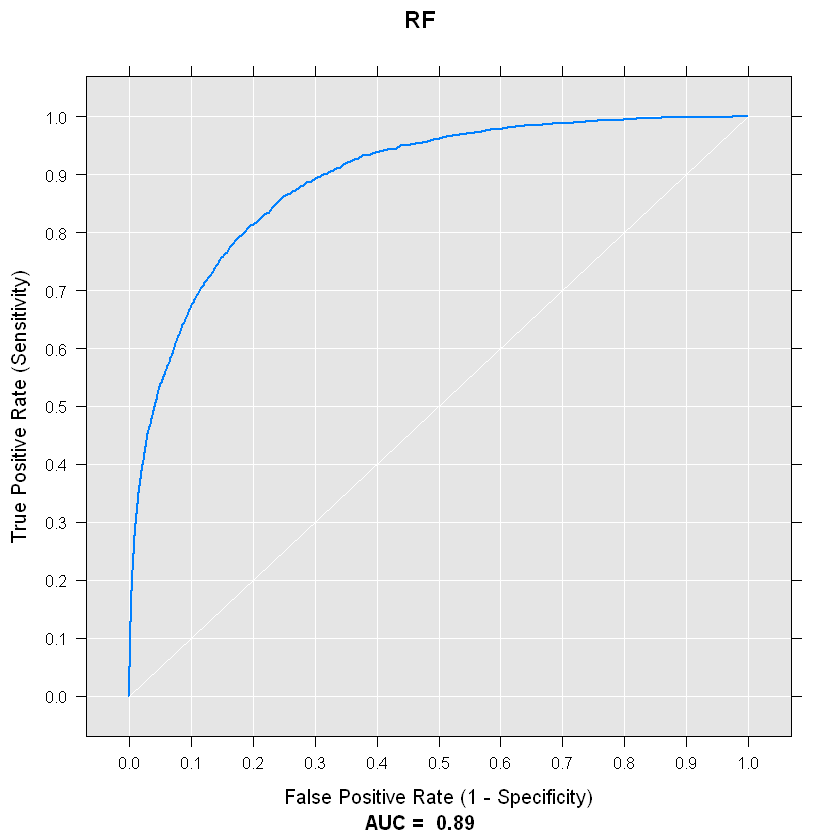

In [98]:
# Random Forest Scoring

## Make Predictions, then import them into R. The observed Conversion_Flag is kept through extraVarsToWrite.
Prediction_Table_RF <- RxSqlServerData(table = "Prediction_Table_RF", stringsAsFactors = T, 
                                       connectionString = connection_string)
rxPredict(forest_model, data = CM_AD_Test, outData = Prediction_Table_RF, overwrite = T, type = "prob",
          extraVarsToWrite = c("Conversion_Flag"))
Prediction_RF <- rxImport(inData = Prediction_Table_RF, stringsAsFactors = T, outFile = NULL)
observed <- Prediction_RF$Conversion_Flag

## Assign the decision threshold to the median of the predicted probabilities.
threshold <- median(Prediction_RF$`1_prob`)

## Compute the performance metrics of the model. The Compute Context should be set to local. 
rxSetComputeContext(local)
Metrics_RF <- evaluate_model(observed = observed, predicted_probability = Prediction_RF$`1_prob`,threshold = threshold,
                             model_name = "RF")

## Set back the compute context to SQL.
rxSetComputeContext(sql)

Rows Read: 30282, Total Rows Processed: 30282, Total Chunk Time: 0.109 seconds 
[1] "GBT"
        predicted
observed     0     1
       0 14698 12533
       1   446  2605


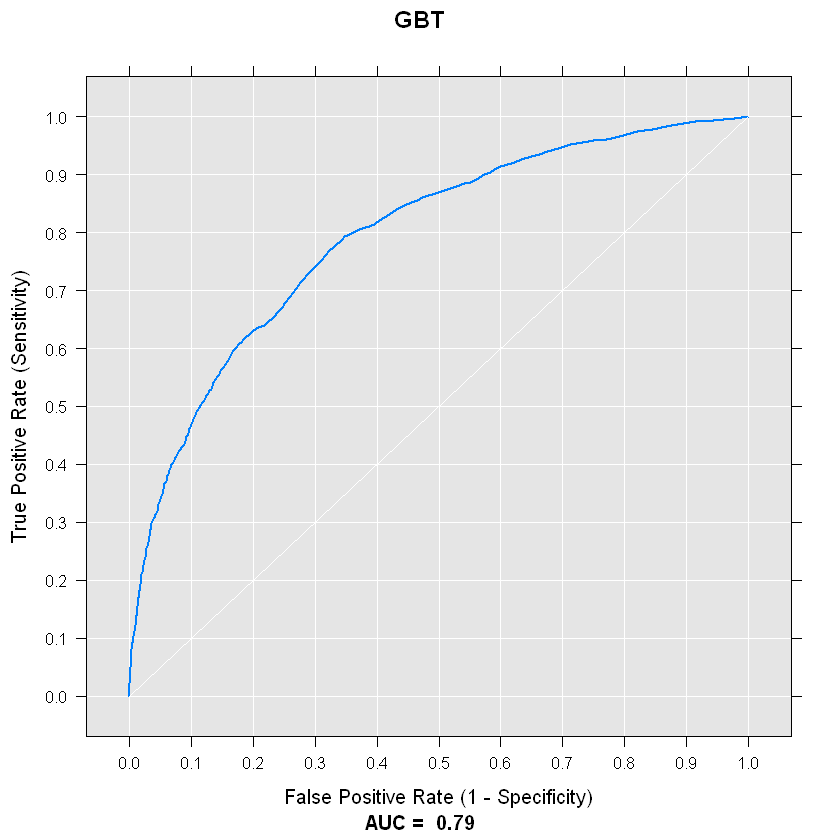

In [99]:
# Gradient Boosted Trees Scoring 

## Make Predictions, then import them into R. The observed Conversion_Flag is kept through extraVarsToWrite.
Prediction_Table_GBT <- RxSqlServerData(table = "Prediction_Table_GBT", stringsAsFactors = T, 
                                        connectionString = connection_string)

rxPredict(btree_model,data = CM_AD_Test, outData = Prediction_Table_GBT, overwrite = T, type = "prob",
          extraVarsToWrite = c("Conversion_Flag"))
Prediction_GBT <- rxImport(inData = Prediction_Table_GBT, stringsAsFactors = T, outFile = NULL)
observed <- Prediction_GBT$Conversion_Flag

## Assign the decision threshold to the median of the predicted probabilities.
threshold <- median(Prediction_GBT$`1_prob`)

## Compute the performance metrics of the model. The Compute Context should be set to local.
rxSetComputeContext(local)
Metrics_GBT <- evaluate_model(observed = observed, predicted_probability = Prediction_GBT$`1_prob`,
                              threshold = threshold, model_name = "GBT")

## Set back the compute context to SQL.
rxSetComputeContext(sql)

In [95]:
# Select the best model based on AUC
if(Metrics_RF$AUC >= Metrics_GBT$AUC){
    best <- "RF"
    best_model <- forest_model
} else {
    best <- "GBT"
    best_model <- btree_model
}

print(best)

[1] "RF"


## Step 4: Channel-Day-Time Recommendations

We determine recommendations for each Lead_Id:  best combination of Day, Channel, and Time to target him.
The best combination is the one with the highest probability of conversion given by the selected model.
This will help the business acheive a higher conversion rate.

In this step we:

**1.** Create a full data table with  all the unique combinations of Day_Of_Week, Channel, Time_Of_Day. 

**2.** Get the predicted probabilities for each Lead_Id, for all combinations of Day_Of_Week, Channel, Time_Of_Day, with best_model.

**3.** For each Lead_Id, choose the combination that has the highest conversion probability.

**Input** : Data set CM_AD and the best prediction model, best_model. 

**Output**: Recommended Day_Of_Week, Channel and Time_Of_Day for each Lead_Id.

In [61]:
# Create a full data table with all the unique combinations of Day_of_Week, Channel, Time_Of_Day 

## Create a table with all the unique combinations of Day_of_Week, Channel, Time_Of_Day.
Day_of_Week_unique <- data.frame(seq(1, 7))
Channel_unique <-data.frame(c("Email", "Cold Calling", "SMS"))
Time_Of_Day_unique <- data.frame(c("Morning", "Afternoon", "Evening"))
Unique_Combos <- merge(merge(Day_of_Week_unique, Channel_unique), Time_Of_Day_unique)
colnames(Unique_Combos) <- c("Day_Of_Week", "Channel", "Time_Of_Day")

## Export it to SQL
Unique_Combos_sql <- RxSqlServerData(table = "Unique_Combos_sql", connectionString = connection_string)
rxDataStep(inData = Unique_Combos, outFile = Unique_Combos_sql, overwrite = T)

## We create a table that has, for each Lead_Id and its corresponding variables (except Day_of_Week, Channel, Time_Of_Day),
## One row for each possible combination of Day_of_Week, Channel and Time_Of_Day.
## This is a pointer. The table will be created on the fly while scoring. 

AD_full_merged_sql <- RxSqlServerData(
  sqlQuery = "SELECT * 
              FROM (
                    SELECT Lead_Id, Age, Annual_Income_Bucket, Credit_Score, State, No_Of_Dependents, Highest_Education, Ethnicity,
                    No_Of_Children, Household_Size, Gender, Marital_Status, Campaign_Id, Product_Id, Term,
                    No_of_people_covered, Premium, Payment_frequency, Amt_on_Maturity_Bin, Sub_Category, Campaign_Drivers,
                    Tenure_Of_Campaign, Net_Amt_Insured, SMS_Count, Email_Count,  Call_Count, 
                    Previous_Channel, Conversion_Flag
                    FROM CM_AD) a,
                    (SELECT * FROM Unique_Combos_sql) b", 
  stringsAsFactors = T, connectionString = connection_string, colInfo = column_info)


Rows Read: 63, Total Rows Processed: 63
Total Rows written: 63, Total time: 0
, Total Chunk Time: 0.062 seconds 


In [62]:
# Compute the predicted probabilities for each Lead_Id, for each combination of Day, Channel, Time, using best_model

## Score the full data by using the best model.
Prob_Id <- RxSqlServerData(table = "Prob_Id ", stringsAsFactors = T, connectionString = connection_string)
rxPredict(best_model, data = AD_full_merged_sql, outData = Prob_Id, overwrite = T, type = "prob",
          extraVarsToWrite = c("Lead_Id", "Day_Of_Week", "Time_Of_Day", "Channel"))

In [63]:
# For each Lead_Id, choose a combination of Day, Channel, and Time that has the highest conversion probability    

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Recommended_Combinations;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT Lead_Id, Day_of_Week, Channel, Time_Of_Day, MaxProb
 INTO Recommended_Combinations
 FROM (
       SELECT maxp.Lead_Id, Day_of_Week, Channel, Time_Of_Day, MaxProb, 
              ROW_NUMBER() OVER (partition by maxp.Lead_Id ORDER BY NEWID()) as RowNo
       FROM ( SELECT Lead_Id, max([1_prob]) as MaxProb
              FROM Prob_Id
              GROUP BY Lead_Id) maxp
       JOIN Prob_Id 
       ON (maxp.Lead_Id = Prob_Id.Lead_Id AND maxp.MaxProb = Prob_Id.[1_prob])
  ) candidates
  WHERE RowNo = 1;"
, sep=""))

In [100]:
# Add demographics information to the recommendation table  

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Recommendations;"
, sep=""))

rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("
SELECT Age, Annual_Income_Bucket, Credit_Score, Product, Campaign_Name as [Campaign Name], State,  
       Conversion_Flag as Converts, CM_AD.Day_Of_Week as [Day of Week], CM_AD.Time_Of_Day as [Time of Day],
       CM_AD.Channel, CM_AD.Lead_Id as [Lead ID], Recommended_Combinations.Day_Of_Week as [Recommended Day],
       Recommended_Combinations.Time_Of_Day as [Recommended Time], Recommended_Combinations.MaxProb,
       Recommended_Combinations.Channel as [Recommended Channel]
INTO Recommendations
FROM CM_AD JOIN Recommended_Combinations
ON CM_AD.Lead_Id = Recommended_Combinations.Lead_Id;"
, sep=""))

In [ ]:
# Drop intermediate table.
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Recommended_Combinations;"
, sep=""))

Rows Read: 50000, Total Rows Processed: 50000, Total Chunk Time: 1.047 seconds
Rows Read: 50000, Total Rows Processed: 100000, Total Chunk Time: 1.062 seconds 


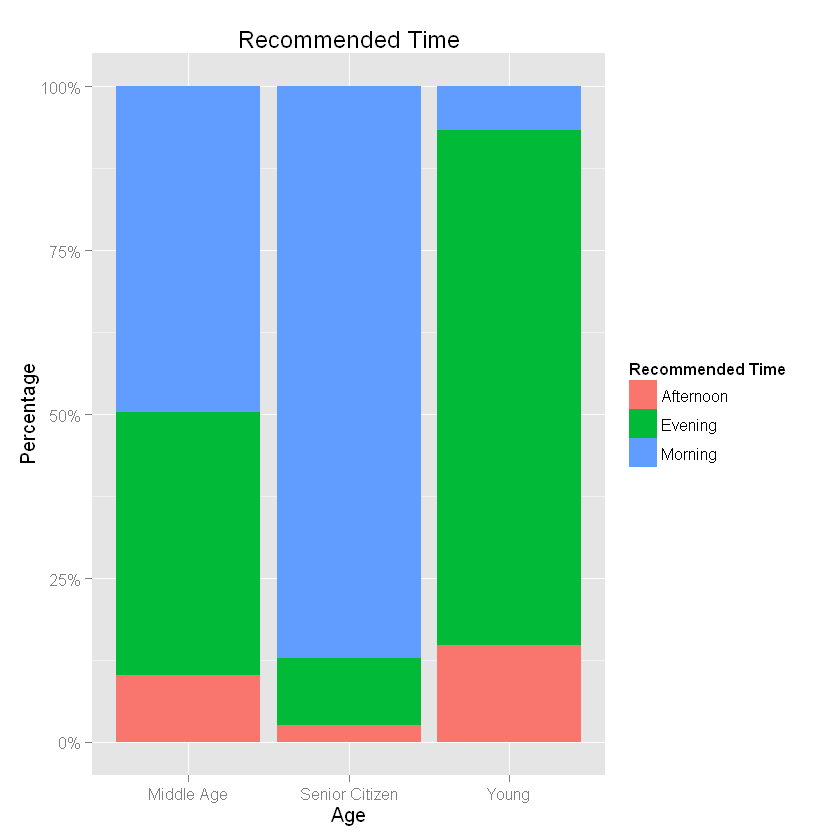

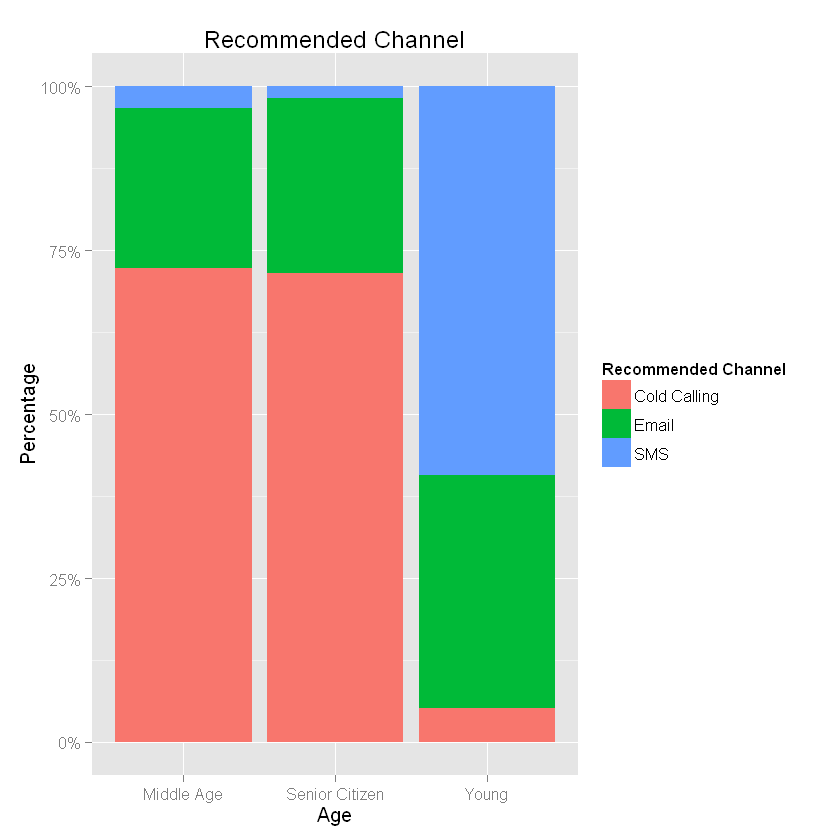

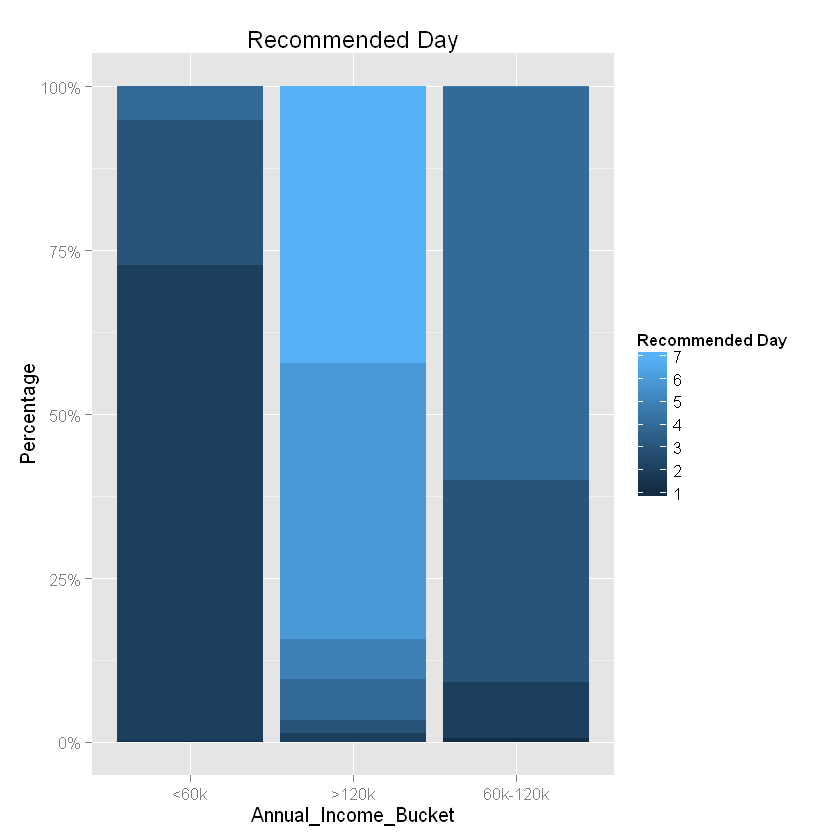

In [132]:
# Draw bar plots to visualize correlations 

## Import Recommendations table from SQL Server.
Recommendations <- RxSqlServerData(table = "Recommendations ", connectionString = connection_string)
Rec <- rxImport(Recommendations)

## Recommended Time
pt <- table(Rec$`Recommended Time`, Rec$Age)
datat <- melt(pt)
colnames(datat) <- c("Recommended Time", "Age", "Percentage")

ggplot(datat, aes(x = Age ,y = Percentage, fill =`Recommended Time`)) + 
    geom_bar(position = "fill",stat = "identity") + 
    scale_y_continuous(labels = percent_format()) + 
    ggtitle("Recommended Time")


In [ ]:
## Recommended Channel 
pc <- table(Rec$`Recommended Channel`, Rec$Age)

datac <- melt(pc)
colnames(datac) <- c("Recommended Channel", "Age", "Percentage")

ggplot(datac, aes(x = Age ,y = Percentage, fill =`Recommended Channel`)) + 
    geom_bar(position = "fill",stat = "identity") + 
    scale_y_continuous(labels = percent_format()) + 
    ggtitle("Recommended Channel")

In [ ]:
## Recommended Day 
pd <- table(Rec$`Recommended Day`, Rec$Annual_Income_Bucket)

datad <- melt(pd)
colnames(datad) <- c("Recommended Day", "Annual_Income_Bucket", "Percentage")

ggplot(datad, aes(x = Annual_Income_Bucket ,y = Percentage, fill =`Recommended Day`)) + 
    geom_bar(position = "fill",stat = "identity") + 
    scale_y_continuous(labels = percent_format()) + 
    ggtitle("Recommended Day")